In [1]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode

Populating the interactive namespace from numpy and matplotlib


In [2]:
M_E = 5.972e24
R_E = 6.371e6
x_h = 0.05
rho_c = 3.e3
chi = 0.23
d_hE = 3e3
rho_m = 3.3e3
d_melt = 60.e3
f_degasE = 0.9
G = 6.67e-11
P_E = 4.e7
f_M = 0.68
f_b = 0.9
omega_0 = 2.3e-4
f_btwid = 1.3
year = 3.154e+7
omg_Etwid = 6.2e-4/2.3e-4

In [3]:
#print 5.8e-4*f_M/(omega_0*f_btwid)

In [4]:
gamma = rho_m*d_melt*f_degasE*omega_0*f_btwid/(x_h*rho_c*chi*d_hE*f_M)
tau = M_E*omega_0*f_btwid/(1.5*2.*math.pi*R_E*0.1/year*x_h*rho_c*chi*d_hE)
#print tau/(1.e9*year)

### Convection scheme (standard boundary-layer, no core)

In [5]:
E_a = 335.e3
R_g = 8.314
alpha = 2.e-5
Ra_c = 1100.
kappa = 1.e-6
T_ref = 1600.
#eta_0 = 1.e21
#eta_0 = 1.e16
k = 4.2
beta = 0.3
c_p = 1200.
Q_0 = 5.e-8
year = 3.154e+7

In [6]:
def Rp(M):
    return R_E*(M/M_E)**(0.27)
def Rc(M): 
    return .547*R_E*(M/M_E)**(0.247)
def h(M):
    return Rp(M)-Rc(M)
def V(M):
    return 4./3.*math.pi*(Rp(M)**3. - Rc(M)**3.)
def A(M):
    return 4.*math.pi*Rp(M)**2.
def rho_av(M):
    return (M-(0.3259*M))/V(M)
def g(M):
    return G*M/(Rp(M)**2.)
def gtwid(M):
    return g(M)/9.8

In [7]:
C0 = -7.9859
C1 = 4.3559
C2 = -0.5742
C3 = 0.0337
f_M = 0.68
f_btwid = 1.3
omega_0 = 2.3e-4
M_oliv = 153.31
M_wat = 18.01528
x_fact = (omega_0*f_btwid)/f_M
B = M_oliv/M_wat*x_fact
def lnfugacity(x,temp):
    y = np.log(2.e6*x*B/(1.-(x*B)))
    return C0 + C1*y + C2*y**2 + C3*y**3
#nonlinear eta
r=1.
eta_scale = (np.exp(lnfugacity(1,T_ref)))**(-r)
eta_0 = 1.e21/eta_scale
#eta_0 = 1.e21
#print eta_0
#print eta_scale

In [8]:
#other eta param -- CYCLES ALL WATER OUT OF MANTLE, DOESN'T GO BACK IN --
# NOT IN TAD'S CODE FOR PAPER, SO COMMENTED OUT
#C0 = -7.9859
#C1 = 4.3559
#C2 = -0.5742
#C3 = 0.0337
#f_M = 0.68
#f_btwid = 1.3
#omega_0 = 2.3e-4
#M_oliv = 153.31
#M_wat = 18.01528
#A_w = 26.
#E_w = 40.e3
#x_fact = (omega_0*f_btwid)/f_M
#B = M_oliv/M_wat*x_fact
#def lnfugacity(x,temp):
#    C = x*B/(1.-(x*B))
#    return np.log(C/A_w*np.exp(E_w/(R_g*T_ref*temp)))
#    #y = np.log(2.e6*x*B/(1.-(x*B)))
#    #return C0 + C1*y + C2*y**2 + C3*y**3
##nonlinear eta
#r=1.
#eta_scale = (np.exp(lnfugacity(1.,T_ref)))**(-r)
#eta_0 = 1.e21/eta_scale
##eta_0 = 1.e21
##print eta_0
##print eta_scale

In [9]:
def tau_1_inv(M):
    return M*omega_0*f_btwid/(1.5*2.*math.pi*R_E*0.1/year*x_h*rho_c*chi*d_hE)
def omega(M): 
    return k*T_ref**(1.+beta)*A(M)/(h(M)*V(M))*(alpha*rho_m*g(M)*h(M)**3.*np.exp(lnfugacity(1,T_ref))/(Ra_c*kappa*eta_0))**(beta)
def tau_2_inv(M):
    return rho_m*c_p*T_ref/omega(M)
def Q_0twid(M):
    return Q_0/omega(M)
def taudecaytwid(M):
    return 2.e9*year/tau_2_inv(M)
def Qtwid(t,M):
    return math.exp(-t/taudecaytwid(M))
T_s = 280.
T_stwid = T_s/T_ref
T_mtwid = T_ref*R_g/(E_a)
#print tau_1_inv(M_E)/(3.156e7*1.e9)
#print tau_2_inv(M_E)/(3.156e7*1.e9)
def tau_2_inv_re(M):
    return rho_m*c_p*T_ref/Q_0
#print tau_2_inv_re(M_E)/(3.156e7*1.e9)

In [10]:
def f_conv_water(t,temp,x,M):
    return Q_0twid(M)*Qtwid(t,M) - ((np.exp(lnfugacity(x,temp))/np.exp(lnfugacity(1,T_ref)))**(beta)*(temp - T_stwid)**(beta+1.)*math.exp(-beta/T_mtwid*((1./temp) - 1.)))

### Water cycling scheme (from S+S)

In [11]:
#constants
K_cnst = 43.
gamma_cnst = 0.75
f_M = 0.68
theta_cnst = 1.5
Ktwid = K_cnst/T_ref
lambda_twid = Ktwid*(omega_0*f_btwid/f_M)**(gamma_cnst)
chi_r = 0.03
chi_d = 0.02
T_serp = 973.
#use more realistic values of liquidus and solidus later!!!
T_liq = 1225.+273.15
T_sol = 975.+273.15
T_liqtwid = T_liq/T_ref
T_soltwid = T_sol/T_ref
def L_MOR(M):
    return 1.5*2.*math.pi*Rp(M)

In [12]:
N = rho_m*d_melt*chi_d*omega_0*f_btwid/f_M*(T_liqtwid-T_soltwid)**(-theta_cnst)
def Pi(M):
    return x_h*rho_c*chi_r*h(M)**(1.-3.*beta)*(T_serp-T_s)/(T_ref**(1.+beta))*(kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*(np.exp(lnfugacity(1.,T_ref)))))**(beta)
def Ntwid(M):
    return N/Pi(M)
def Sigma(M):
    return M*omega_0*f_btwid*h(M)**(1.-6.*beta)*kappa**(2.*beta-1)/(10.76*L_MOR(M))*(Ra_c*eta_0/(alpha*rho_m*g(M)*T_ref*(np.exp(lnfugacity(1.,T_ref)))))**(2.*beta)
def tau_4_inv(M):
    return Sigma(M)/Pi(M)
#print tau_4_inv(M_E)/(3.156e7*1.e9)

In [13]:
def f_M_feed(t,temp,x,M):
    return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1.,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - Ntwid(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1.,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)

In [14]:
def f_all_wat_feed(t,z,M):
    temp = z[0]
    x = z[1]
    return [tau_1_inv(M)/tau_2_inv(M)*f_conv_water(t,temp,x,M),tau_1_inv(M)/tau_4_inv(M)*f_M_feed(t,temp,x,M)]


### Now add hydrated layer depth check

In [15]:
N = rho_m*d_melt*chi_d*omega_0*f_btwid/f_M*(T_liqtwid-T_soltwid)**(-theta_cnst)
def Pi(M):
    return x_h*rho_c*chi_r*h(M)**(1.-3.*beta)*(T_serp-T_s)/(T_ref**(1.+beta))*(kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*(np.exp(lnfugacity(1.,T_ref)))))**(beta)
def Pitwid(M):
    return Pi(M)/N
def Sigma(M):
    return M*omega_0*f_btwid*h(M)**(1.-6.*beta)*kappa**(2.*beta-1)/(10.76*L_MOR(M))*(Ra_c*eta_0/(alpha*rho_m*g(M)*T_ref*(np.exp(lnfugacity(1.,T_ref)))))**(2.*beta)
def tau_4_inv(M):
    return Sigma(M)/N
#print tau_4_inv(M_E)/(3.156e7*1.e9)

In [16]:
def Pi_2(M):
    return h(M)**(1.-3.*beta)*(T_serp-T_s)/(T_ref**(1.+beta))*(kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*(np.exp(lnfugacity(1,T_ref)))))**(beta)
def Pi_2_1(temp,x,M):
    return x_h*rho_c*chi_r*(Rp(M)-(Rp(M)**3. - 3./4.*omega_0*f_btwid*M*(omegatwid-x)/(math.pi*x_h*rho_m))**(1./3.))*np.exp(-beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(1.+beta)
Pi_c = 0.
def f_M_feed(t,temp,x,M):
    if temp-T_soltwid+lambda_twid*x**(gamma_cnst) > 0.:
        if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
            return Pitwid(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
        elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
            return Pi_2_1(temp,x,M)/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
        elif (omegatwid - x) <= 0:
            return Pi_c/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
    else:
        if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
            return Pitwid(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(0.)**(theta_cnst)
        elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
            return Pi_2_1(temp,x,M)/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(0.)**1.5
        elif (omegatwid - x) <= 0:
            return Pi_c/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(0.)**(theta_cnst)

In [17]:
def dhydr_real_SS(temp,x,M):
    if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
        return Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1.,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta))
    elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
        return Pi_2_1(temp,x,M)/(x_h*rho_c*chi_r)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1.,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta))

In [18]:
def f_M_feed_in(t,temp,x,M):
    if temp-T_soltwid+lambda_twid*x**(gamma_cnst) > 0.:
        if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
            return Pitwid(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))
        elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
            return Pi_2_1(temp,x,M)/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))
        elif (omegatwid - x) <= 0:
            return Pi_c/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))
    else:
        if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
            return Pitwid(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))
        elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
            return Pi_2_1(temp,x,M)/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))
        elif (omegatwid - x) <= 0:
            return Pi_c/N*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))

In [19]:
def f_M_feed_out(t,temp,x,M):
    if temp-T_soltwid+lambda_twid*x**(gamma_cnst) > 0.:
        if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
            return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
        elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
            return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
        elif (omegatwid - x) <= 0:
            return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(temp-T_soltwid+lambda_twid*x**(gamma_cnst))**(theta_cnst)
    else:
        if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
            return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(0.)**(theta_cnst)
        elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
            return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(0.)**1.5
        elif (omegatwid - x) <= 0:
            return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(0.)**(theta_cnst)

In [20]:
def f_all_wat_feed(t,z,M):
    temp = z[0]
    x = z[1]
    return [tau_1_inv(M)/tau_2_inv(M)*f_conv_water(t,temp,x,M),tau_1_inv(M)/tau_4_inv(M)*f_M_feed(t,temp,x,M)]

In [21]:
#x0_x,t0_x = 5.8e-4*0.68/(2.3e-4*1.3), 0.
omegatwid = omg_Etwid/(f_btwid)
x0_x,t0_x = omegatwid/2., 0.
sigma = 1.
mu = 1.
x0,t0 = 2., 0.
M = 1.*M_E
z0=[x0,x0_x]
#r = ode(f_fug,jac_fug).set_integrator('vode', with_jacobian=True)
r = ode(f_all_wat_feed).set_integrator('vode')
#r.set_initial_value(z0, t0).set_f_params(gtwid,omegatwid,sigma,mu,M).set_jac_params(gtwid,omegatwid,sigma,mu,M)
r.set_initial_value(z0,t0).set_f_params(M)
t1 = 100.
dt = 1.e-5
t_array_SS = np.zeros(int(t1/dt))
T_array_SS = np.zeros(int(t1/dt))
x_array_SS = np.zeros(int(t1/dt))
in_array_SS = np.zeros(int(t1/dt))
out_array_SS = np.zeros(int(t1/dt))
d_hydr_SS = np.zeros(int(t1/dt))
idx = 0
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_SS[idx] = r.t
    T_array_SS[idx] = r.y[0]
    x_array_SS[idx] = r.y[1]
    in_array_SS[idx] = f_M_feed_in(r.t,r.y[0],r.y[1],M)
    out_array_SS[idx] = f_M_feed_out(r.t,r.y[0],r.y[1],M)
    d_hydr_SS[idx] = dhydr_real_SS(r.y[0],r.y[1],M)
    idx = idx + 1

In [22]:
#print M_E*omega_0*f_btwid*(omegatwid-x_array_SS[-1])
#earth ocean mass is 1.4e21

### Hybrid model (degassing Kite, regassing S+S)

In [23]:
D = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
def tau_5_inv(M):
    return Sigma(M)/D #Sigma/E in paper
def tau_5_inv_re(M):
    return Sigma(M)/Pi(M)
#print tau_5_inv(M_E)/(3.156e7*1.e9)
#print tau_5_inv_re(M_E)/(3.156e7*1.e9)
def Pitwid_2(M):
    return Pi(M)/D #D/E in paper

In [24]:
def Pi_2(M):
    return h(M)**(1.-3.*beta)*(T_serp-T_s)/(T_ref**(1.+beta))*(kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*(np.exp(lnfugacity(1,T_ref)))))**(beta)
def Pi_2_1(temp,x,M):
    return x_h*rho_c*chi_r*(Rp(M)-(Rp(M)**3. - 3./4.*omega_0*f_btwid*M*(omegatwid-x)/(math.pi*x_h*rho_m))**(1./3.))*np.exp(-beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(1.+beta)
Pi_c = 0.
def f_M_feed_hybrid(t,temp,x,M):
    if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
        return Pitwid_2(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(gtwid(M)**2.*(omegatwid-x))**(-1.)
    elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
        return Pi_2_1(temp,x,M)/D*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(gtwid(M)**2.*(omegatwid-x))**(-1.)
    if (omegatwid - x) <= 0:
        return Pi_c/D*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) - (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1.,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x


In [25]:
def f_M_feed_hybrid_out(t,temp,x,M):
    if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
        return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(gtwid(M)**2.*(omegatwid-x))**(-1.)
    elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
        return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x*(gtwid(M)**2.*(omegatwid-x))**(-1.)
    if (omegatwid - x) <= 0:
        return (np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1.,T_ref))))**(2.*beta)*(temp-T_stwid)**(2.*beta)*np.exp(-2.*beta/T_mtwid*((1./temp)-1.))*x
def f_M_feed_hybrid_in(t,temp,x,M):
    if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
        return Pitwid_2(M)*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) 
    elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
        return Pi_2_1(temp,x,M)/D*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.)) 
    if (omegatwid - x) <= 0:
        return Pi_c/D*(np.exp(lnfugacity(x,temp))/(np.exp(lnfugacity(1,T_ref))))**(beta)*(temp-T_stwid)**(beta-1)*np.exp(-beta/T_mtwid*((1./temp)-1.))

In [26]:
def dhydr(temp,x,M):
    return Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1.,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta))

In [27]:
def dhydr_real(temp,x,M):
    if 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) <= M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
        return Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1.,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta))
    elif 4./3.*math.pi*x_h*rho_m*(Rp(M)**3.-(Rp(M) - Pi_2(M)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta)))**3.) > M*omega_0*f_btwid*(omegatwid-x) and (omegatwid - x) > 0:
        return Pi_2_1(temp,x,M)/(x_h*rho_c*chi_r)*np.exp(beta/T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)/np.exp(lnfugacity(1.,T_ref))))**(-beta)*(temp-T_stwid)**(-(1.+beta))

In [28]:
def delta(temp,x,M):
    return h(M)*(Ra_c*eta_0*np.exp(1./T_mtwid*((1./temp)-1))*(np.exp(lnfugacity(x,temp)))**(-1)*kappa/(alpha*rho_m*g(M)*T_ref*(temp-T_stwid)*h(M)**3.))**(beta)

In [29]:
dhydr_a = []
delta_a = []
temp_a = []
temp = 0.5
while temp <= 2.5:
    dhydr_a.append(dhydr(temp,1,M_E))
    delta_a.append(delta(temp,1,M_E))
    temp_a.append(temp)
    temp = temp + 0.1
    

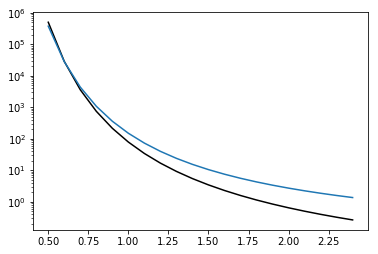

In [30]:
semilogy(temp_a,np.divide(dhydr_a,1.e3),'k',temp_a,np.divide(delta_a,1.e3))
#dhydr always less than delta (unless T tiny, in which it becomes like the radius of the planet..), good!!

In [31]:
def f_all_wat_feed_hybrid(t,z,M):
    temp = z[0]
    x = z[1]
    return [tau_1_inv(M)/tau_2_inv(M)*f_conv_water(t,temp,x,M),tau_1_inv(M)/tau_5_inv(M)*f_M_feed_hybrid(t,temp,x,M)]


In [32]:
#x0_x,t0_x = 5.8e-4*0.68/(2.3e-4*1.3), 0.
omegatwid = omg_Etwid/(f_btwid)
x0_x,t0_x = omegatwid/2., 0.
sigma = 1.
mu = 1.
x0,t0 = 2., 0.
M = 1.*M_E
z0=[x0,x0_x]
#r = ode(f_fug,jac_fug).set_integrator('vode', with_jacobian=True)
r = ode(f_all_wat_feed_hybrid).set_integrator('vode')
#r.set_initial_value(z0, t0).set_f_params(gtwid,omegatwid,sigma,mu,M).set_jac_params(gtwid,omegatwid,sigma,mu,M)
r.set_initial_value(z0,t0).set_f_params(M)
t1 = 100.
dt = 1.e-5
t_array_hyb = np.zeros(int(t1/dt))
T_array_hyb = np.zeros(int(t1/dt))
x_array_hyb = np.zeros(int(t1/dt))
in_array_hyb = np.zeros(int(t1/dt))
out_array_hyb = np.zeros(int(t1/dt))
d_hydr_hyb = np.zeros(int(t1/dt))
idx = 0
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_hyb[idx] = r.t
    T_array_hyb[idx] = r.y[0]
    x_array_hyb[idx] = r.y[1]
    in_array_hyb[idx] = f_M_feed_hybrid_in(r.t,r.y[0],r.y[1],M)
    out_array_hyb[idx] = f_M_feed_hybrid_out(r.t,r.y[0],r.y[1],M)
    d_hydr_hyb[idx] = dhydr_real(r.y[0],r.y[1],M)
    idx = idx + 1

### Compare different schemes

In [33]:
#CA, coupling to T from x (but no x from T)
mu = 1.
sigma = 1.
def f_M(t,x,gtwid,omegatwid,sigma,mu,M):
    return (gtwid(M)**2.*(omegatwid-x))**sigma - gamma*x*(gtwid(M)**2.*(omegatwid-x))**(-mu)
def f_conv_water(t,temp,x,M):
    #add Q(t) but ignore and water effects for now
    return Q_0twid(M)*Qtwid(t,M) - ((np.exp(lnfugacity(x,temp))/np.exp(lnfugacity(1,T_ref)))**(beta)*(temp - T_stwid)**(beta+1.)*math.exp(-beta/T_mtwid*((1./temp) - 1.)))

def f_fug(t,z,gtwid,omegatwid,sigma,mu,M):
    #add Q(t) and water effects 
    temp = z[0]
    x = z[1]
    return [tau_1_inv(M)/tau_2_inv(M)*f_conv_water(t,temp,x,M),f_M(t,x,gtwid,omegatwid,sigma,mu,M)]

In [34]:
def dhydr_CA(x,M):
    return d_hE*gtwid(M)**2.*(omegatwid-x)**sigma

In [35]:
#x0_x,t0_x = 5.8e-4*0.68/(2.3e-4*1.3), 0.
omegatwid = omg_Etwid/(f_btwid)
x0_x,t0_x = omegatwid/2., 0.
sigma = 1.
mu = 1.
x0,t0 = 2., 0.
M = 1.*M_E
z0=[x0,x0_x]
#r = ode(f_fug,jac_fug).set_integrator('vode', with_jacobian=True)
r = ode(f_fug).set_integrator('vode')
#r.set_initial_value(z0, t0).set_f_params(gtwid,omegatwid,sigma,mu,M).set_jac_params(gtwid,omegatwid,sigma,mu,M)
r.set_initial_value(z0,t0).set_f_params(gtwid,omegatwid,sigma,mu,M)
t1 = 100.
dt = 1.e-5
t_array_CA = np.zeros(int(t1/dt))
T_array_CA = np.zeros(int(t1/dt))
x_array_CA = np.zeros(int(t1/dt))
in_array_CA = np.zeros(int(t1/dt))
out_array_CA = np.zeros(int(t1/dt))
d_hydr_CA = np.zeros(int(t1/dt))
idx = 0
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_CA[idx] = r.t
    T_array_CA[idx] = r.y[0]
    x_array_CA[idx] = r.y[1]
    in_array_CA[idx] = (gtwid(M)**2.*(omegatwid-r.y[1]))**sigma
    out_array_CA[idx] = gamma*r.y[1]*(gtwid(M)**2.*(omegatwid-r.y[1]))**(-mu)
    d_hydr_CA[idx] = dhydr_CA(r.y[1],M)
    idx = idx + 1
    #print(r.t, r.y)

In [36]:
M_E = 5.972e24
R_E = 6.371e6
x_h = 0.05
rho_c = 3.e3
chi = 0.23
d_hE = 3e3
rho_m = 3.3e3
d_melt = 60.e3
f_degasE = 0.9
G = 6.67e-11
P_E = 4.e7
f_M = 0.68
f_b = 0.9
omega_0 = 2.3e-4
f_btwid = 1.3
year = 3.154e+7
omg_Etwid = 6.2e-4/2.3e-4

In [37]:
def M_hydr(d_h):
    return 4./3.*math.pi*(R_E**3. - (R_E-d_h)**3.)*x_h*rho_m
i = 0
M_hydr_SS = []
M_hydr_CA = []
M_hydr_hyb = []
while i < len(t_array_SS):
    M_hydr_SS.append(M_hydr(d_hydr_SS[i]))
    M_hydr_hyb.append(M_hydr(d_hydr_hyb[i]))
    M_hydr_CA.append(M_hydr(d_hydr_CA[i]))
    i = i + 1
#M_hydr_twid = M_hydr/M_E
#print M_hydr_twid

In [38]:
M_hydr = 4./3.*math.pi*(R_E**3. - (R_E-d_hydr_hyb[-1])**3.)*x_h*rho_c
M_hydr_twid = M_hydr/M_E
#print M_hydr_twid
#print omegatwid - x_array_hyb[-1]

/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


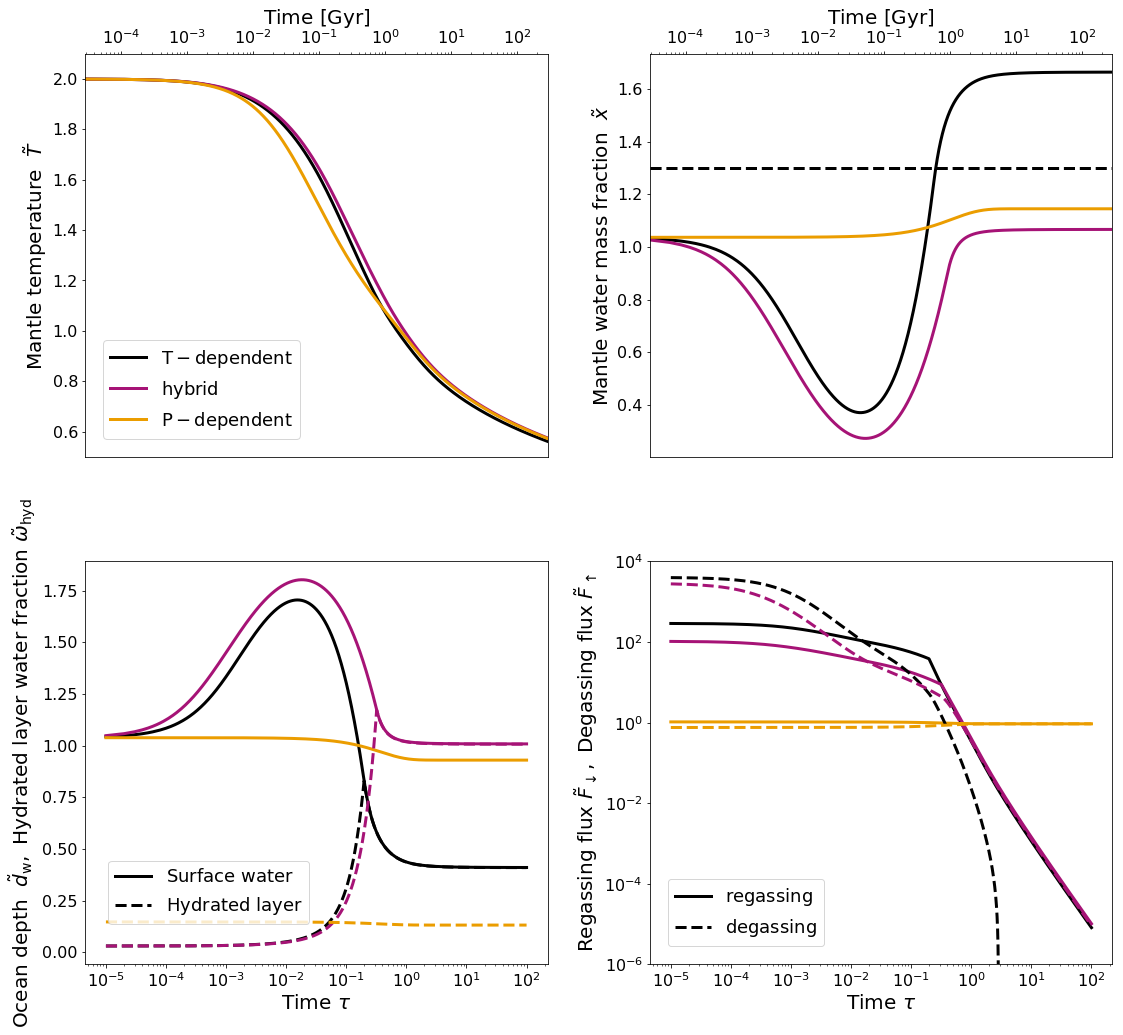

In [39]:
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)
fig = plt.figure()
fig.set_size_inches(16,15)
ax1 = fig.add_subplot(221)
nlines = 3
colormap = plt.cm.gnuplot
ax1.set_color_cycle([colormap(i) for i in np.linspace(0., 0.85, nlines)])
ax1.semilogx(np.multiply(t_array_SS,tau_1_inv(M_E)/(3.156e7*1.e9)),T_array_SS,label=r'$\mathrm{T-dependent}$',linewidth=3)
ax1.semilogx(np.multiply(t_array_hyb,tau_1_inv(M_E)/(3.156e7*1.e9)),T_array_hyb,label=r'$\mathrm{hybrid}$',linewidth=3)
ax1.semilogx(np.multiply(t_array_CA,tau_1_inv(M_E)/(3.156e7*1.e9)),T_array_CA,label=r'$\mathrm{P-dependent}$',linewidth=3)

ax2 = fig.add_subplot(222)
ax2.axhline(1.3,linewidth=3,color='k',linestyle='--')
nlines = 3
colormap = plt.cm.gnuplot
ax2.set_color_cycle([colormap(i) for i in np.linspace(0., 0.85, nlines)])
ax2.semilogx(np.multiply(t_array_SS,tau_1_inv(M_E)/(3.156e7*1.e9)),x_array_SS,label=r'$\tilde{M} = 0.5$',linewidth=3)
ax2.semilogx(np.multiply(t_array_hyb,tau_1_inv(M_E)/(3.156e7*1.e9)),x_array_hyb,label=r'$\tilde{M} = 1$',linewidth=3)
ax2.semilogx(np.multiply(t_array_CA,tau_1_inv(M_E)/(3.156e7*1.e9)),x_array_CA,label=r'$\tilde{M} = 5$',linewidth=3)

ax3 = fig.add_subplot(223)
#ax3.axhline(0.75,linewidth=3,color='k',linestyle='--')
nlines = 3
colormap = plt.cm.gnuplot
ax3.set_color_cycle([colormap(i) for i in np.linspace(0., 0.85, nlines)])
ax3.semilogx(t_array_SS,np.multiply(gtwid(M_E),np.subtract(omegatwid,x_array_SS)),label=r'$\mathrm{Surface} \ \mathrm{water}$',linewidth=3)
ax3.semilogx(t_array_hyb,np.multiply(gtwid(M_E),np.subtract(omegatwid,x_array_hyb)),linewidth=3)
ax3.semilogx(t_array_CA,np.multiply(gtwid(M_E),np.subtract(omegatwid,x_array_CA)),linewidth=3)
nlines = 3
colormap = plt.cm.gnuplot
ax3.set_color_cycle([colormap(i) for i in np.linspace(0., 0.85, nlines)])
ax3.semilogx(t_array_SS,np.multiply(M_hydr_SS,1./(omega_0*f_btwid*M_E)),linewidth=3,label=r'$\mathrm{Hydrated} \ \mathrm{layer}$',linestyle='--')
ax3.semilogx(t_array_hyb,np.multiply(M_hydr_hyb,1./(omega_0*f_btwid*M_E)),linewidth=3,linestyle='--')
ax3.semilogx(t_array_CA,np.multiply(M_hydr_CA,1./(omega_0*f_btwid*M_E)),linewidth=3,linestyle='--')

ax4 = fig.add_subplot(224)
#ax4.axhline(1.,linewidth=3,color='k',linestyle='--')
nlines = 3
colormap = plt.cm.gnuplot
ax4.set_color_cycle([colormap(i) for i in np.linspace(0., 0.85, nlines)])
ax4.loglog(t_array_SS,in_array_SS,label=r'$\mathrm{regassing}$',linewidth=3)
ax4.loglog(t_array_hyb,in_array_hyb,linewidth=3)
ax4.loglog(t_array_CA,in_array_CA,linewidth=3)
ax4.loglog(t_array_SS,out_array_SS,label=r'$\mathrm{degassing}$',linestyle='--',linewidth=3)
ax4.loglog(t_array_hyb,out_array_hyb,linestyle='--',linewidth=3)
ax4.loglog(t_array_CA,out_array_CA,linestyle='--',linewidth=3)

#ax3.axvline(1.,linewidth=3,color='k',linestyle='--')
#ax4.axvline(1.,linewidth=3,color='k',linestyle='--')

#ax1.legend(numpoints=1,ncol=1, loc=3, 
 #          borderaxespad=0.5,prop={'size':16})
ax4.set_xlabel(r'$\mathrm{Time} \ \tau$')
ax3.set_xlabel(r'$\mathrm{Time} \ \tau$')
ax1.set_xlabel(r'$\mathrm{Time} \ [\mathrm{Gyr}]$')
ax2.set_xlabel(r'$\mathrm{Time} \ [\mathrm{Gyr}]$')



ax4.set_ylabel(r'$\mathrm{Regassing} \ \mathrm{flux} \ \tilde{F}_{\downarrow}, \ \mathrm{Degassing} \ \mathrm{flux} \ \tilde{F}_{\uparrow}$')


ax2.set_ylabel(r'$\mathrm{Mantle} \ \mathrm{water} \ \mathrm{mass} \ \mathrm{fraction} \ \ \tilde{x}$')
ax3.set_ylabel(r'$\mathrm{Ocean} \ \mathrm{depth} \ \ \tilde{d}_{\mathrm{w}}, \ \mathrm{Hydrated} \ \mathrm{layer} \ \mathrm{water} \ \mathrm{fraction} \ \tilde{\omega}_{\mathrm{hyd}}}$')


ax1.legend(numpoints=1,ncol=1, loc=3, 
           borderaxespad=1.,prop={'size':18})
ax3.legend(numpoints=1,ncol=1, loc=3, bbox_to_anchor=(.05, 0.1), 
           borderaxespad=0.,prop={'size':18})
ax4.legend(numpoints=1,ncol=1, loc=3, 
           borderaxespad=1.,prop={'size':18})


#ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$\mathrm{Mantle} \ \mathrm{temperature} \ \ \tilde{T}$')
ax1.set_ylim(0.5,2.1)
ax1.set_xlim(1.e-5*tau_1_inv(M_E)/(3.156e7*1.e9),1.e2*tau_1_inv(M_E)/(3.156e7*1.e9))
ax2.set_xlim(1.e-5*tau_1_inv(M_E)/(3.156e7*1.e9),1.e2*tau_1_inv(M_E)/(3.156e7*1.e9))
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top') 
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom='off')
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom='off')
ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off')
ax4.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off')



#ax2.set_ylim(0.,omegatwid)
#ax1.get_xaxis().set_ticks([])
#ax2.get_xaxis().set_ticks([])
#ax3.get_xaxis().set_ticks([])
ax4.set_ylim(1.e-6,1.e4)




fig.tight_layout()



savefig('comparison_xT_tau_waterdepth_4col.pdf',bbox_inches='tight')

In [ ]:
#print(np.shape(omegatwid), np.min(omegatwid), np.max(omegatwid))
#print(np.shape(x_array_hyb), np.min(x_array_hyb), np.max(x_array_hyb))
# Save these for easier plotting in the next cell.
t_tau_hyb = np.multiply(t_array_hyb,tau_1_inv(M_E)/(3.156e7*1.e9))
omega_x_hyb = np.subtract(omegatwid,x_array_hyb)

In [ ]:
%matplotlib inline

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.figure(figsize=(12,6))
plt.subplot(121)
#plt.semilogx(t_array_SS,np.multiply(gtwid(M_E),np.subtract(omegatwid,x_array_SS)),label=r'$\mathrm{Surface} \ \mathrm{water}$',linewidth=3, color='r')
#plt.semilogx(t_array_hyb,np.multiply(gtwid(M_E),np.subtract(omegatwid,x_array_hyb)),linewidth=3, color='k')
plt.semilogx(t_array_hyb,omega_x_hyb,linewidth=3, color='b')
#plt.semilogx(t_array_CA,np.multiply(gtwid(M_E),np.subtract(omegatwid,x_array_CA)),linewidth=3, color='b')
plt.xlabel(r'$\mathrm{Time} \ \tau$')
#plt.ylabel(r'$\mathrm{Ocean} \ \mathrm{depth} \ \ \tilde{d}_{\mathrm{w}}, \ \mathrm{Hydrated} \ \mathrm{layer} \ \mathrm{water} \ \mathrm{fraction} \ \tilde{\omega}_{\mathrm{hyd}}}$')
plt.ylabel(r'$\mathrm{Surface water mass fraction} \tilde{\omega} - \tilde{x}$')

plt.subplot(122)
plt.semilogx(t_tau_hyb,x_array_hyb,linewidth=3)
plt.xlabel(r'$\mathrm{Time} \ \tau$')
plt.ylabel(r'$\mathrm{Mantle water mass fraction} \tilde{x}$')
plt.savefig('SurfaceWater_and_MantleWater.png')

#plt.legend(numpoints=1,ncol=1, loc=3, bbox_to_anchor=(.05, 0.1), 
#           borderaxespad=0.,prop={'size':18})

In [ ]:
# Commented out r and r.set... lines commented back in, with the others commented out, to see what it outputs.

#x0_x,t0_x = 5.8e-4*0.68/(2.3e-4*1.3), 0.
omegatwid = omg_Etwid/(f_btwid)
x0_x,t0_x = omegatwid/2., 0.
sigma = 1.
mu = 1.
x0,t0 = 2., 0.
M = 1.*M_E
z0=[x0,x0_x]
#r = ode(f_fug).set_integrator('vode', with_jacobian=True)
r = ode(f_all_wat_feed_hybrid).set_integrator('vode')
#r.set_initial_value(z0, t0).set_f_params(gtwid,omegatwid,sigma,mu,M).set_jac_params(gtwid,omegatwid,sigma,mu,M)
r.set_initial_value(z0,t0).set_f_params(M)
t1 = 100.
dt = 1.e-5
t_array_hyb_new = np.zeros(int(t1/dt))
T_array_hyb_new = np.zeros(int(t1/dt))
x_array_hyb_new = np.zeros(int(t1/dt))
in_array_hyb_new = np.zeros(int(t1/dt))
out_array_hyb_new = np.zeros(int(t1/dt))
d_hydr_hyb_new = np.zeros(int(t1/dt))
idx = 0
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_hyb_new[idx] = r.t
    T_array_hyb_new[idx] =r.y[0]
    x_array_hyb_new[idx] = r.y[1]
    in_array_hyb_new[idx] = f_M_feed_hybrid_in(r.t,r.y[0],r.y[1],M)
    out_array_hyb_new[idx] = f_M_feed_hybrid_out(r.t,r.y[0],r.y[1],M)
    d_hydr_hyb_new[idx] = dhydr_real(r.y[0],r.y[1],M)
    idx = idx + 1
    
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogx(t_array_hyb_new[0::50], x_array_hyb_new[0::50], 'b')
plt.subplot(122)
plt.semilogx(t_array_hyb_new[0::50], np.subtract(omegatwid,x_array_hyb_new[0::50]), 'k')

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogx(t_array_hyb[0::100], x_array_hyb[0::100], 'b')
plt.subplot(122)
plt.semilogx(t_array_hyb[0::100], np.subtract(omegatwid,x_array_hyb[0::100]), 'k')

In [ ]:
# Try to have timesteps in log-time, equally spaced when plotted.
# Analytic way to estimate timestep/error? Estimate of what our time resolution needs to be. 
# --> Look into numerical methods to a priori determine the timestep.
# Fix integration loop to not append.

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogx(t_array_SS[0::100], x_array_SS[0::100], 'b')
plt.subplot(122)
plt.semilogx(t_array_SS[0::100], np.subtract(omegatwid,x_array_SS[0::100]), 'k')